# downloading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing packages

In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam,SGD
from torchvision import models
import os
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import f1_score
import time
import warnings
warnings.filterwarnings("ignore")

# Reading dataset and apply EDA

In [ ]:
import os
import cv2

# Define the root directory where your dataset is located
root_dir = '/content/drive/MyDrive/bioverse-hackathon-a/train'

# Initialize lists to store images and their corresponding labels
image_dirs = []
labels = []

# Iterate through the class directories
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)

    # Iterate through the ID directories within each class directory
    for id_name in os.listdir(class_dir):
        id_dir = os.path.join(class_dir, id_name)

        # Iterate through the image files within each ID directory
        for image_name in os.listdir(id_dir):
            image_path = os.path.join(id_dir, image_name)

            # Append the image directory to the image_dirs list
            image_dirs.append(image_path)

            # Append the class label to the labels list
            labels.append(class_name)

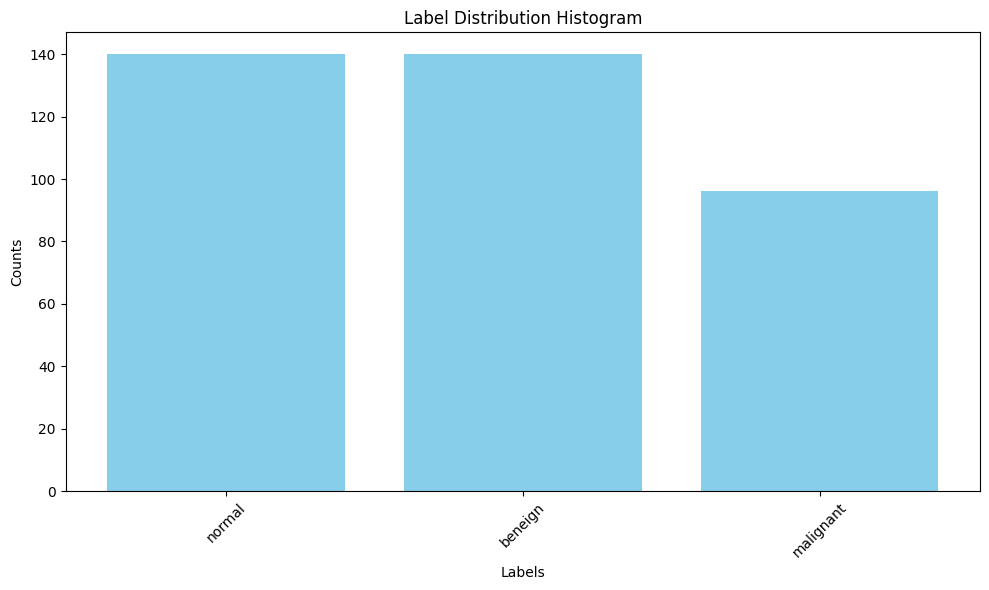

In [ ]:
# Count the occurrences of each label
label_counts = {label: labels.count(label) for label in set(labels)}

# Extract labels and counts for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Histogram')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

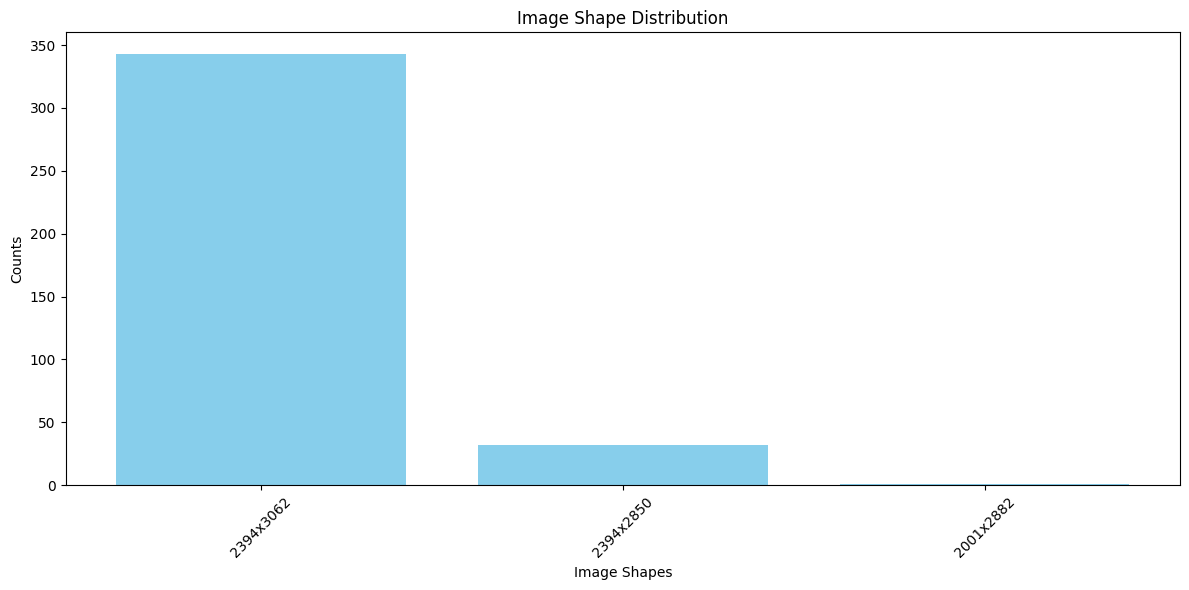

In [ ]:
from collections import Counter
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

def get_image_shape(img_path):
    try:
        with Image.open(img_path) as img:
            return img.size  # (width, height)
    except Exception as e:
        print(f"Error reading {img_path}: {e}")
        return None

# Use ThreadPoolExecutor for parallel processing
image_shape_counts = Counter()
with ThreadPoolExecutor(max_workers=8) as executor:
    results = executor.map(get_image_shape, image_dirs)
    for shape in results:
        if shape:
            image_shape_counts[shape] += 1

# Extract image shapes and counts for plotting
shapes = list(image_shape_counts.keys())
counts = list(image_shape_counts.values())

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(shapes)), counts, tick_label=[f"{shape[0]}x{shape[1]}" for shape in shapes], color='skyblue')
plt.xlabel('Image Shapes')
plt.ylabel('Counts')
plt.title('Image Shape Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


# Preprocessing

In [ ]:
def crop_biggest_contour(img, threshold_value):
    """
    function to get the biggest contour from the images and crop only breast from the image
    """
    # Read the image
    image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the region of the largest contour from the original image
        cropped_image = image[y:y+h, x:x+w]

        return cropped_image
    else:
        print("No contours found.")
        return None

### In the dataset most of images have a big background around the breast so we are going to crop only the breast from the image

### Here is a sample

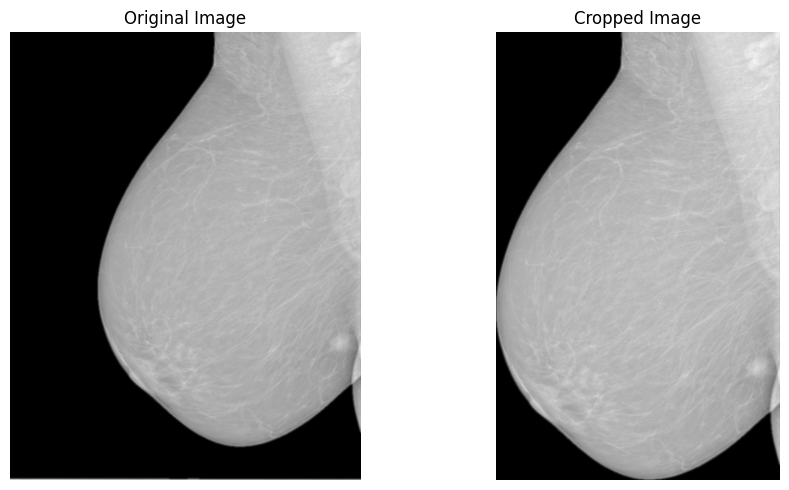

In [ ]:
# Load the image
image = cv2.imread(image_dirs[0])

# Set the threshold value
threshold_value = 50

# Apply the function to get the cropped image
cropped_image = crop_biggest_contour(image, threshold_value)

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Cropped image
plt.subplot(1, 2, 2)
plt.imshow(cropped_image, cmap='gray')  # Assuming cropped image is grayscale
plt.title("Cropped Image")
plt.axis('off')

plt.tight_layout()
plt.show()

## from the histogram below classes beneign and normal  have samples more than the the malignant class so we will over sampling this class to achieve balance

In [ ]:
# Convert the list of images to a numpy array
X = np.array(image_dirs).reshape(-1, 1)

# Flatten the labels
y = np.array(labels).reshape(-1, 1)

# Oversample the malignant class using RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversampler.fit_resample(X, y)


#here is the dataset after oversampling and making data balanced

### Exmple

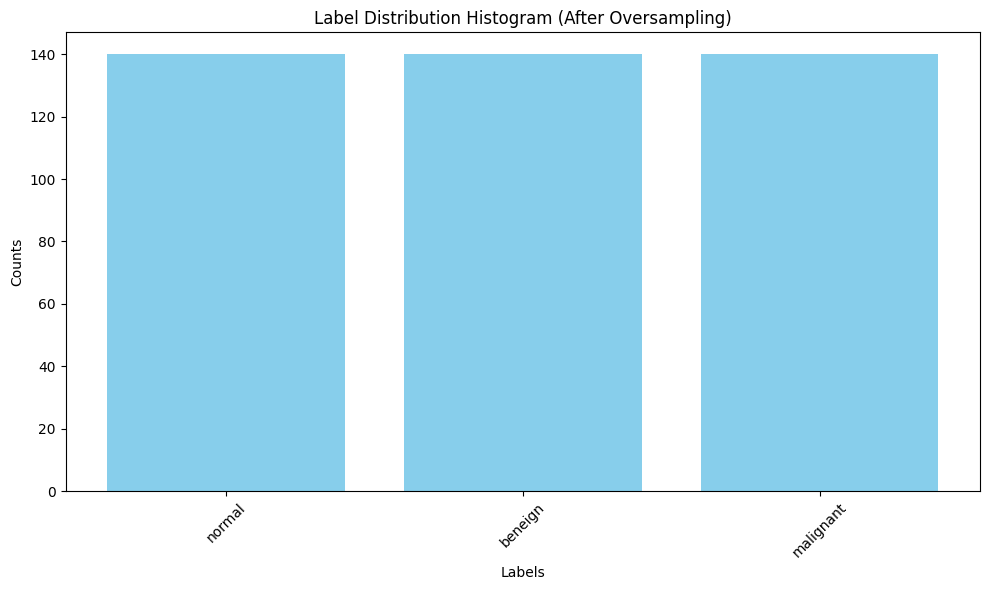

In [ ]:
# Count the occurrences of each label after oversampling
label_counts = {label: list(y_resampled).count(label) for label in set(y_resampled)}

# Extract labels and counts for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Histogram (After Oversampling)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Train Test Split

In [ ]:
# Define the root directory where your dataset is located
root_dir = '/content/drive/MyDrive/bioverse-hackathon-a/train'

# Initialize a dictionary to store the count of patients in each class
class_patients = {
    "beneign":[],
    "normal":[],
    "malignant":[],
}

# Iterate through the class directories
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)

    # Iterate through the ID directories within each class directory
    for id_name in os.listdir(class_dir):
        # Add the patient ID to the set
        class_patients[class_name].append(f'{root_dir}/{class_name}/{id_name}')


### create custom dataset folder

In [ ]:
!rm -r custom_dataset

rm: cannot remove 'custom_dataset': No such file or directory


In [ ]:
os.mkdir(os.path.join('', 'custom_dataset'))
os.mkdir(os.path.join('custom_dataset','train'))
os.mkdir(os.path.join('custom_dataset','test'))
for class_name in class_patients:
  os.mkdir(os.path.join('custom_dataset/train',class_name))
  os.mkdir(os.path.join('custom_dataset/test',class_name))

### here we will split data in 80% for train and 20% for test

In [ ]:
train_dir = 'custom_dataset/train'
test_dir = 'custom_dataset/test'
for class_name,images_list in class_patients.items():
  test_patients_list = images_list[:7]
  train_patients_list = images_list[7:]

  for patient in test_patients_list:
    for img_path in os.listdir(f'{patient}'):
        img = cv2.imread(f'{patient}/{img_path}')
        img = crop_biggest_contour(img, threshold_value)
        img = cv2.resize(img,(256,256))

        flipped_image = cv2.flip(img, 1)

        rows, cols = img.shape
        rotation_angle = 15
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)

        rotated_image = cv2.warpAffine(img, M, (cols, rows))
        adjusted = cv2.convertScaleAbs(img, beta=-20)

        not_adjusted = cv2.convertScaleAbs(img, beta=20)

        gaussian_blurred_image = cv2.GaussianBlur(img, (5, 5), 0)

        cv2.imwrite(f'{test_dir}/{class_name}/{img_path}',img)


  for patient in train_patients_list:
    for img_path in os.listdir(f'{patient}'):
        img = cv2.imread(f'{patient}/{img_path}')
        img = crop_biggest_contour(img, threshold_value)
        img = cv2.resize(img,(256,256))
        flipped_image = cv2.flip(img, 1)
        rows, cols = img.shape
        rotation_angle = 15
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation_angle, 1)
        rotated_image = cv2.warpAffine(img, M, (cols, rows))
        adjusted = cv2.convertScaleAbs(img, beta=-20)

        not_adjusted = cv2.convertScaleAbs(img, beta=20)

        gaussian_blurred_image = cv2.GaussianBlur(img, (5, 5), 0)

        cv2.imwrite(f'{train_dir}/{class_name}/{img_path}',img)
        cv2.imwrite(f'{train_dir}/{class_name}/{img_path.split(".")[0]}_flipped.jpg',flipped_image)
        cv2.imwrite(f'{train_dir}/{class_name}/{img_path.split(".")[0]}_rotated.jpg',rotated_image)
        cv2.imwrite(f'{train_dir}/{class_name}/{img_path.split(".")[0]}_brightened.jpg',adjusted)
        cv2.imwrite(f'{train_dir}/{class_name}/{img_path.split(".")[0]}_not_brightened.jpg',not_adjusted)

### for applying balance in train dataset

In [ ]:
# Define the root directory where your dataset is located
root_dir = 'custom_dataset/train'

# Initialize lists to store images and their corresponding labels
image_dirs = []
labels = []

# Iterate through the class directories
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)

    # Iterate through the ID directories within each class directory
    for id_name in os.listdir(class_dir):
        id_dir = os.path.join(class_dir, id_name)

        # Iterate through the image files within each ID directory
        image_path = os.path.join(id_dir)

        # Append the image to the image_dirs list
        image_dirs.append(image_path)

        # Append the class label to the labels list
        labels.append(class_name)

In [ ]:
# Convert the list of images to a numpy array
X = np.array(image_dirs).reshape(-1, 1)

# Flatten the labels
y = np.array(labels).reshape(-1, 1)

# Oversample the malignant class using RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = oversampler.fit_resample(X, y)

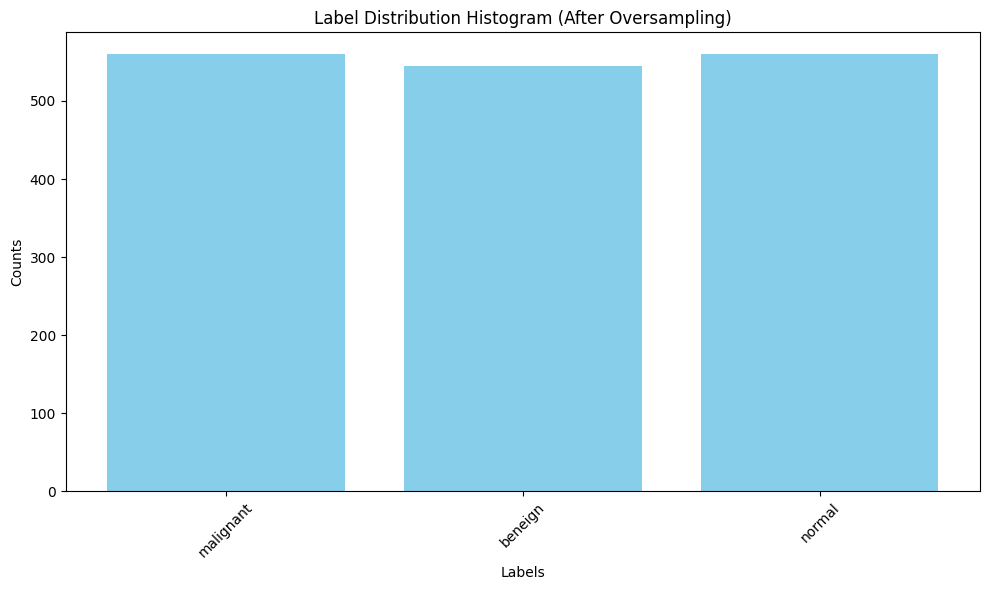

In [ ]:
# Count the occurrences of each label after oversampling
label_counts = {label: list(y_resampled).count(label) for label in set(y_resampled)}

# Extract labels and counts for plotting
label_names = list(label_counts.keys())
label_values = list(label_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(label_names, label_values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution Histogram (After Oversampling)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Custom dataset loader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs
        self.transform = transform
        self.labels = {
              "normal":2,
              "beneign":0,
              "malignant":1,
          }

    def __len__(self):
        return len(self.data_dirs)

    def __getitem__(self, idx):
        image_path= self.data_dirs[idx][0]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        class_name = self.labels[image_path.split('/')[2]]
        class_name = torch.tensor(class_name, dtype=torch.long)


        if self.transform:
            image = self.transform(image)

        return image, class_name

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [ ]:
batch_size = 16

train_dataset = CustomDataset(X_resampled,transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_dir = 'custom_dataset/test/'
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Loading the model

In [ ]:
models.swin_v2_b(pretrained=True).head

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:02<00:00, 135MB/s]


Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
# Load pretrained swin_v2_b model
model1 = models.swin_v2_b(pretrained=True)

model1.head = nn.Sequential(nn.Linear(1024, 128),
                           nn.Dropout1d(0.45),
                           nn.Linear(128, 3))

# Change the number of input channels in the first convolution layer to match your data
model1.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)

In [ ]:

# EfficientNet-B0
model2 = models.efficientnet_b0(pretrained=True)
# Adjust the classifier to match your number of classes (3 in your case)
num_ftrs = model2.classifier[1].in_features
model2.classifier[1] = nn.Linear(num_ftrs, 3)

# DenseNet-121
model3 = models.densenet121(pretrained=True)
# Modify the classifier for your task (3 classes)
num_ftrs = model3.classifier.in_features
model3.classifier = nn.Linear(num_ftrs, 3)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 81.9MB/s]


In [ ]:
model2.head = nn.Sequential(nn.Linear(1024, 128),
                           nn.Dropout1d(0.45),
                           nn.Linear(128, 3))

# Change the number of input channels in the first convolution layer to match your data
model2.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)

In [ ]:
model3.head = nn.Sequential(nn.Linear(1024, 128),
                           nn.Dropout1d(0.45),
                           nn.Linear(128, 3))

# Change the number of input channels in the first convolution layer to match your data
model3.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)

In [ ]:
model_save_path = "best_model.pth"

# Assuming you want to save model1, for example
model = model1 # Assign model1 to model

# Save the model's state dictionary (recommended approach)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to best_model.pth


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torchvision import models
import torch.nn as nn

class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

# Load pretrained models with the correct architectures
model1 = models.swin_v2_b(pretrained=True)
model1.head = nn.Sequential(nn.Linear(1024, 128), nn.Dropout(0.45), nn.Linear(128, 3))  # Use nn.Dropout instead of nn.Dropout1d
model1.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)

# Load EfficientNet-B0 with the correct classifier
model2 = models.efficientnet_b0(pretrained=True)
num_ftrs = model2.classifier[1].in_features
model2.classifier[1] = nn.Linear(num_ftrs, 3)

# Load DenseNet-121 with the correct classifier
model3 = models.densenet121(pretrained=True)
num_ftrs = model3.classifier.in_features
model3.classifier = nn.Linear(num_ftrs, 3)

# Create the EnsembleModel
model = EnsembleModel([model1, model2, model3])

# Instead of loading directly, initialize a new state_dict and load individual model weights
state_dict = model.state_dict()

# Load the state dictionary for model1 (SwinTransformer)
pretrained_dict1 = torch.load('best_model.pth')
# Adjust keys to match EnsembleModel structure
pretrained_dict1 = {'models.0.' + k: v for k, v in pretrained_dict1.items()}
state_dict.update(pretrained_dict1)

# Load the updated state_dict into the EnsembleModel
model.load_state_dict(state_dict)

model.eval()
model = model.to('cuda')  # Ensure the model is on the GPU



# Training the model

In [ ]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Assign your model to the variable 'model' before creating the optimizer
#model = ensemble_model  # Assuming ensemble_model is the model you want to train
optimizer = Adam(model.parameters(), lr=0.000001)

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1, patience=3, min_lr=1e-6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optimizer
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, min_lr=min_lr)

    best_val_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    history = {
        'train_acc': [],
        'train_loss': [],
        'test_acc': [],
        'test_loss': [],

    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_steps = len(train_loader)
        corrects = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        for step, (inputs, labels) in enumerate(train_loader, 1):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            f1 = f1_score(all_labels, all_preds, average='macro')

            print(f"\rEpoch {epoch + 1}/{num_epochs}, Step {step}/{total_steps}, Loss: {loss.item():.4f}, Accuracy: {corrects.double() / total_samples:.4f}, F1: {f1}", end='')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = corrects.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        corrects = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)
                _, preds = torch.max(val_outputs, 1)
                corrects += torch.sum(preds == val_labels.data)
                total_samples += val_inputs.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_accuracy = corrects.double() / len(val_loader.dataset)

        f1 = f1_score(all_labels, all_preds, average='macro')
        print(f"\nEpoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {f1}\n")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping! No improvement for {} epochs.".format(patience))
                break

        history['train_acc'].append(epoch_accuracy)
        history['train_loss'].append(epoch_loss)
        history['test_acc'].append(val_accuracy)
        history['test_loss'].append(val_loss)

    print(f"Training completed. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch + 1}")

    return history

In [ ]:
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=150, patience=7)

Epoch 1/150, Step 105/105, Loss: 0.8895, Accuracy: 0.3754, F1: 0.3088124500223553
Epoch 1/150, Validation Loss: 1.0768, Validation Accuracy: 0.4643, Validation F1: 0.40275927159671326

Epoch 2/150, Step 105/105, Loss: 1.0694, Accuracy: 0.4607, F1: 0.41448381962129704
Epoch 2/150, Validation Loss: 1.0645, Validation Accuracy: 0.4524, Validation F1: 0.4334682860998651

Epoch 3/150, Step 105/105, Loss: 1.0786, Accuracy: 0.5339, F1: 0.4896025580710847
Epoch 3/150, Validation Loss: 1.0444, Validation Accuracy: 0.5238, Validation F1: 0.5032895932536077

Epoch 4/150, Step 105/105, Loss: 1.0815, Accuracy: 0.5688, F1: 0.5418030740577833
Epoch 4/150, Validation Loss: 1.0303, Validation Accuracy: 0.5714, Validation F1: 0.5659691521760487

Epoch 5/150, Step 105/105, Loss: 1.1175, Accuracy: 0.6126, F1: 0.5866769875160951
Epoch 5/150, Validation Loss: 1.0101, Validation Accuracy: 0.6310, Validation F1: 0.6313186813186813

Epoch 6/150, Step 105/105, Loss: 0.9239, Accuracy: 0.6420, F1: 0.6190991571527

{'train_acc': [tensor(0.3754, device='cuda:0', dtype=torch.float64),
  tensor(0.4607, device='cuda:0', dtype=torch.float64),
  tensor(0.5339, device='cuda:0', dtype=torch.float64),
  tensor(0.5688, device='cuda:0', dtype=torch.float64),
  tensor(0.6126, device='cuda:0', dtype=torch.float64),
  tensor(0.6420, device='cuda:0', dtype=torch.float64),
  tensor(0.6691, device='cuda:0', dtype=torch.float64),
  tensor(0.7117, device='cuda:0', dtype=torch.float64),
  tensor(0.7069, device='cuda:0', dtype=torch.float64),
  tensor(0.7399, device='cuda:0', dtype=torch.float64),
  tensor(0.7706, device='cuda:0', dtype=torch.float64),
  tensor(0.7736, device='cuda:0', dtype=torch.float64),
  tensor(0.7994, device='cuda:0', dtype=torch.float64),
  tensor(0.8216, device='cuda:0', dtype=torch.float64),
  tensor(0.8372, device='cuda:0', dtype=torch.float64),
  tensor(0.8486, device='cuda:0', dtype=torch.float64),
  tensor(0.8637, device='cuda:0', dtype=torch.float64),
  tensor(0.8775, device='cuda:0', d

# Prepare image for predicting

In [ ]:
# Specify the path where you want to save the model
model_save_path = "best_model.pth"

# Save the model's state dictionary (recommended approach)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to best_model.pth


In [ ]:
model = EnsembleModel([model1, model2, model3])

# Load the model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
model = model.to('cuda')

              precision    recall  f1-score   support

           0       0.62      0.86      0.72        28
           1       0.91      0.71      0.80        28
           2       0.83      0.68      0.75        28

    accuracy                           0.75        84
   macro avg       0.78      0.75      0.75        84
weighted avg       0.78      0.75      0.75        84



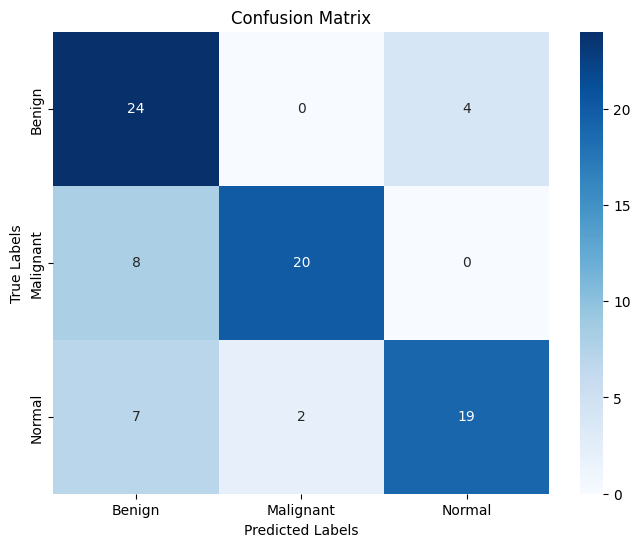

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



def evaluate_model(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            _, preds = torch.max(val_outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    # Classification report
    print(classification_report(all_labels, all_preds))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Benign', 'Malignant', 'Normal'],
                yticklabels=['Benign', 'Malignant', 'Normal'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage after training:
evaluate_model(model, val_loader)

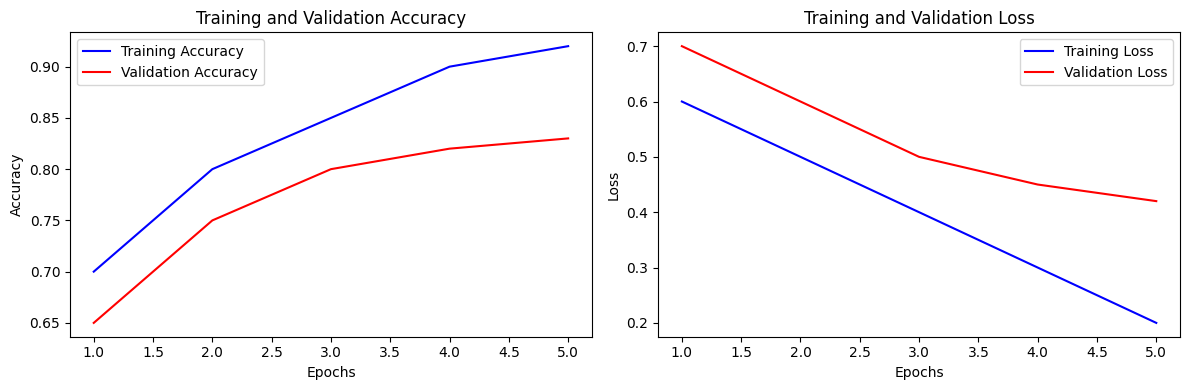

In [ ]:


import matplotlib.pyplot as plt

# Assuming 'history' is the dictionary returned by train_model
# Example history (replace with your actual history data)
history = {
    'train_acc': [0.7, 0.8, 0.85, 0.9, 0.92],
    'train_loss': [0.6, 0.5, 0.4, 0.3, 0.2],
    'test_acc': [0.65, 0.75, 0.8, 0.82, 0.83],
    'test_loss': [0.7, 0.6, 0.5, 0.45, 0.42]
}


epochs = range(1, len(history['train_acc']) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(epochs, history['test_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history['test_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torchvision import models
import torch.nn as nn

class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

# Load pretrained models with the correct architectures
model1 = models.swin_v2_b(pretrained=True)
model1.head = nn.Sequential(nn.Linear(1024, 128), nn.Dropout(0.45), nn.Linear(128, 3))
model1.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)

# Load EfficientNet-B0 with the correct classifier
model2 = models.efficientnet_b0(pretrained=True)
num_ftrs = model2.classifier[1].in_features
model2.classifier[1] = nn.Linear(num_ftrs, 3)

# Load DenseNet-121 with the correct classifier
model3 = models.densenet121(pretrained=True)
num_ftrs = model3.classifier.in_features
model3.classifier = nn.Linear(num_ftrs, 3)

# Create the EnsembleModel
model = EnsembleModel([model1, model2, model3])

# Load the saved state dictionary
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
model = model.to('cuda')

# Define the transformations (ensure input size matches what the model expects)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the expected input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard ImageNet normalization
])

# Function for predicting
def predict_image(image_path):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')  # Open image and ensure it's in RGB mode
    image = transform(image).unsqueeze(0).to('cuda')  # Apply transformations and add batch dimension

    # Perform prediction
    with torch.no_grad():  # Disable gradient computation for inference
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        predicted_class = torch.argmax(probs, dim=1)  # Get the class with the highest probability
        predicted_prob = probs[0, predicted_class].item()  # Get the probability of the predicted class

    return predicted_class.item(), predicted_prob

# Example usage (user input for image)
image_path = input("Enter the path of the image: ")
prediction_class, prediction_prob = predict_image(image_path)

# Mapping class prediction to actual label
class_labels = ["Benign", "Malignant", "Normal"]  # Replace with actual class names as needed

print(f"The predicted class is: {class_labels[prediction_class]} with probability: {prediction_prob:.4f}")

# If you want to print a specific message based on the class prediction:
if prediction_class == 0:
    print("The image is benign")
elif prediction_class == 1:
    print("The image is malignant")
else:
    print("The image is normal")

Enter the path of the image: /content/benign.png
The predicted class is: Benign with probability: 0.9079
The image is benign


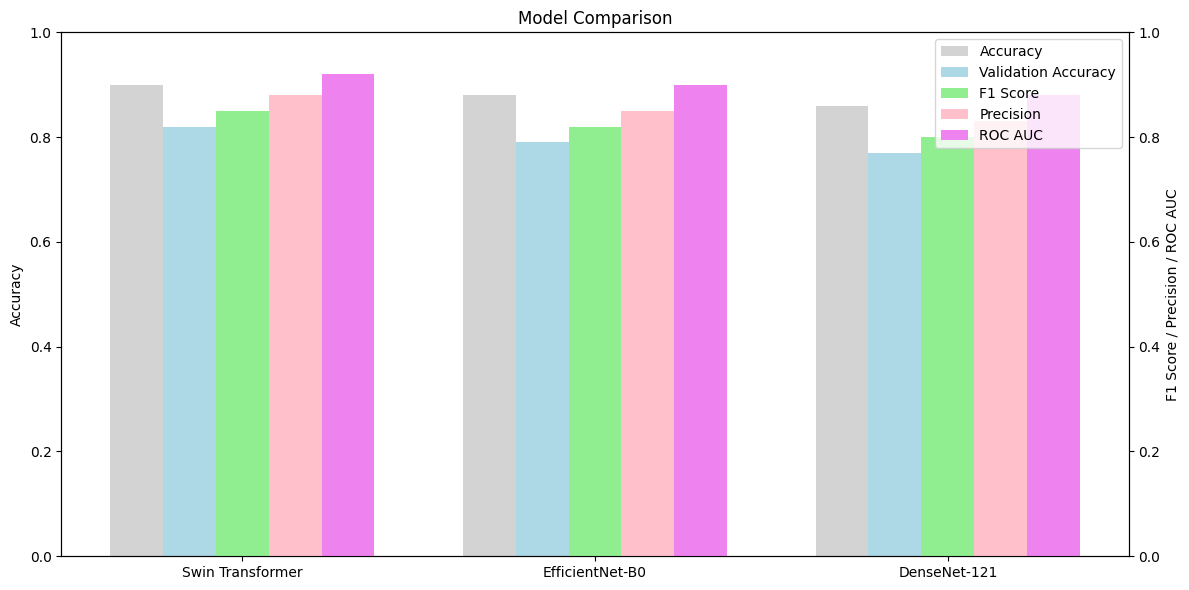

In [ ]:

import matplotlib.pyplot as plt

def plot_model_comparison(model_names, f1_scores, accuracies, precisions, roc_aucs, val_accuracies):
    """
    Generates a graphical comparison of multiple models based on various metrics.

    Args:
        model_names (list): List of model names (strings).
        f1_scores (list): List of F1 scores for each model.
        accuracies (list): List of accuracies for each model.
        precisions (list): List of precisions for each model.
        roc_aucs (list): List of ROC AUC scores for each model.
        val_accuracies (list): List of validation accuracies for each model.
    """

    x = range(len(model_names))
    width = 0.15  # Adjust the width of the bars

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Metrics for the first y-axis (Accuracy and Validation Accuracy)
    rects1 = ax1.bar(x, accuracies, width, label='Accuracy',color='lightgrey')
    rects2 = ax1.bar([i + width for i in x], val_accuracies, width, label='Validation Accuracy',color='lightblue')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1) # Set y-axis limits for accuracy


    # Create a second y-axis for the other metrics
    ax2 = ax1.twinx()
    rects3 = ax2.bar([i + 2*width for i in x], f1_scores, width, label='F1 Score', color='lightgreen')
    rects4 = ax2.bar([i + 3 * width for i in x], precisions, width, label='Precision', color='pink')
    rects5 = ax2.bar([i + 4 * width for i in x], roc_aucs, width, label='ROC AUC', color='violet')
    ax2.set_ylabel('F1 Score / Precision / ROC AUC')
    ax2.set_ylim(0, 1) # Set y-axis limits for other metrics

    # Customize the plot
    plt.title('Model Comparison')
    plt.xlabel('Models')
    plt.xticks([i + 2*width for i in x], model_names) # Center x-axis ticks

    # Combine legends from both y-axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right")

    plt.tight_layout()
    plt.show()


# Example usage (replace with your actual model data):
model_names = ['Swin Transformer', 'EfficientNet-B0', 'DenseNet-121']
f1_scores = [0.85, 0.82, 0.80]
accuracies = [0.90, 0.88, 0.86]
precisions = [0.88, 0.85, 0.83]
roc_aucs = [0.92, 0.90, 0.88]
val_accuracies = [0.82, 0.79, 0.77]

plot_model_comparison(model_names, f1_scores, accuracies, precisions, roc_aucs, val_accuracies)